# 1. Data Preperation

In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [2]:
#Load pre-existing park data
parks_lst_gdf = gpd.read_file('Data/Riyadh_parks_with_LST.geojson')
print("Loaded parks_gdf with columns:", parks_lst_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'Park_id', 'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean',
       'ndvi_pixel_count', 'pisi_mean', 'pisi_pixel_count', 'lst_buffer_30m',
       'lst_buffer_60m', 'lst_buffer_90m', 'lst_buffer_120m',
       'lst_buffer_150m', 'lst_buffer_180m', 'lst_buffer_210m',
       'lst_buffer_240m', 'lst_buffer_270m', 'lst_buffer_300m', 'lst_park',
       'park_pixel_count', 'lst_data', 'cubic_coeffs', 'r_squared', 'PCD',
       'PCI', 'PCA', 'PCE', 'geometry'],
      dtype='object')


In [3]:
# Select relevant columns for the analysis
data_df = parks_lst_gdf[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI', 'PCI', 'PCA', 'PCE']].copy() ## Create a copy of the specified columns to avoid SettingWithCopyWarning

In [4]:
# Check if any row has na

num_rows_with_na = data_df.isna().any(axis=1).sum()
print(f'Number of rows with NaN values: {num_rows_with_na}')


Number of rows with NaN values: 0


Here, the independent variables were normalized using StandardScaler which performs same transformation as the z score method used in litratire [Sun et al., 2024](https://www.sciencedirect.com/science/article/abs/pii/S1618866724000621)

In [5]:
scaler = StandardScaler()

data_df[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']] = scaler.fit_transform(data_df[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']])

In [6]:

# data_df['Cooling_Category'] = data_df['PCI'].apply(lambda x: 'Cooling' if x < 0 else 'Heating')

# 2. Initial Exploration

This section performs Pearson correlation analysis to explore the influence of various factors on LST metrics preliminarily

In [8]:
correlations = data_df.corr()
p_values = pd.DataFrame(index=data_df.columns, columns=data_df.columns)
for col1 in data_df.columns:
    for col2 in data_df.columns:
        corr, p_val = stats.pearsonr(data_df[col1], data_df[col2])
        p_values.loc[col1, col2] = p_val

print("\nPearson Correlation Coefficients:")
print(correlations.round(3))
print("\nP-Values for Correlation Significance:")
print(p_values.round(3))


Pearson Correlation Coefficients:
           ndvi_mean  pisi_mean  area_m2    LSI    PCI    PCA    PCE
ndvi_mean      1.000     -0.802    0.102 -0.100  0.441  0.083 -0.268
pisi_mean     -0.802      1.000   -0.057  0.095 -0.295 -0.017  0.311
area_m2        0.102     -0.057    1.000  0.264  0.507  0.500 -0.334
LSI           -0.100      0.095    0.264  1.000  0.033  0.382 -0.174
PCI            0.441     -0.295    0.507  0.033  1.000  0.406 -0.170
PCA            0.083     -0.017    0.500  0.382  0.406  1.000  0.096
PCE           -0.268      0.311   -0.334 -0.174 -0.170  0.096  1.000

P-Values for Correlation Significance:
          ndvi_mean pisi_mean   area_m2       LSI       PCI       PCA  \
ndvi_mean       0.0       0.0  0.130668  0.140058       0.0  0.218029   
pisi_mean       0.0       0.0  0.397901  0.160858  0.000008  0.796555   
area_m2    0.130668  0.397901       0.0  0.000071       0.0       0.0   
LSI        0.140058  0.160858  0.000071       0.0  0.627981       0.0   
PCI     

- A strong negative correlation between ndvi_mean and pisi_mean (r = -0.802, p = 0.0), indicating an inverse relationship where higher vegetation cover reduces impervious surfaces.
- A moderate positive correlation between ndvi_mean and PCI (r = 0.441, p = 0.0), suggesting that increased vegetation enhances cooling intensity, with parks exhibiting higher NDVI values tending toward negative PCI values.
- A moderate negative correlation between pisi_mean and PCI (r = -0.295, p = 0.000008), implying that greater imperviousness diminishes cooling effects, aligning with urban heat island dynamics.
- A strong positive correlation between area_m2 and both PCI (r = 0.507, p = 0.0) and PCA (r = 0.500, p = 0.0), indicating that larger parks exhibit greater cooling intensity and spatial influence, though efficiency (PCE) decreases with size (r = -0.334, p = 0.0).
- A moderate positive correlation between LSI and PCA (r = 0.382, p = 0.0), suggesting that park shape complexity increases the area of cooling influence, though its impact on PCI and PCE is weak (p > 0.05).
- LSI (r = 0.033, p = 0.627981), indicating shape has minimal linear impact on intensity.

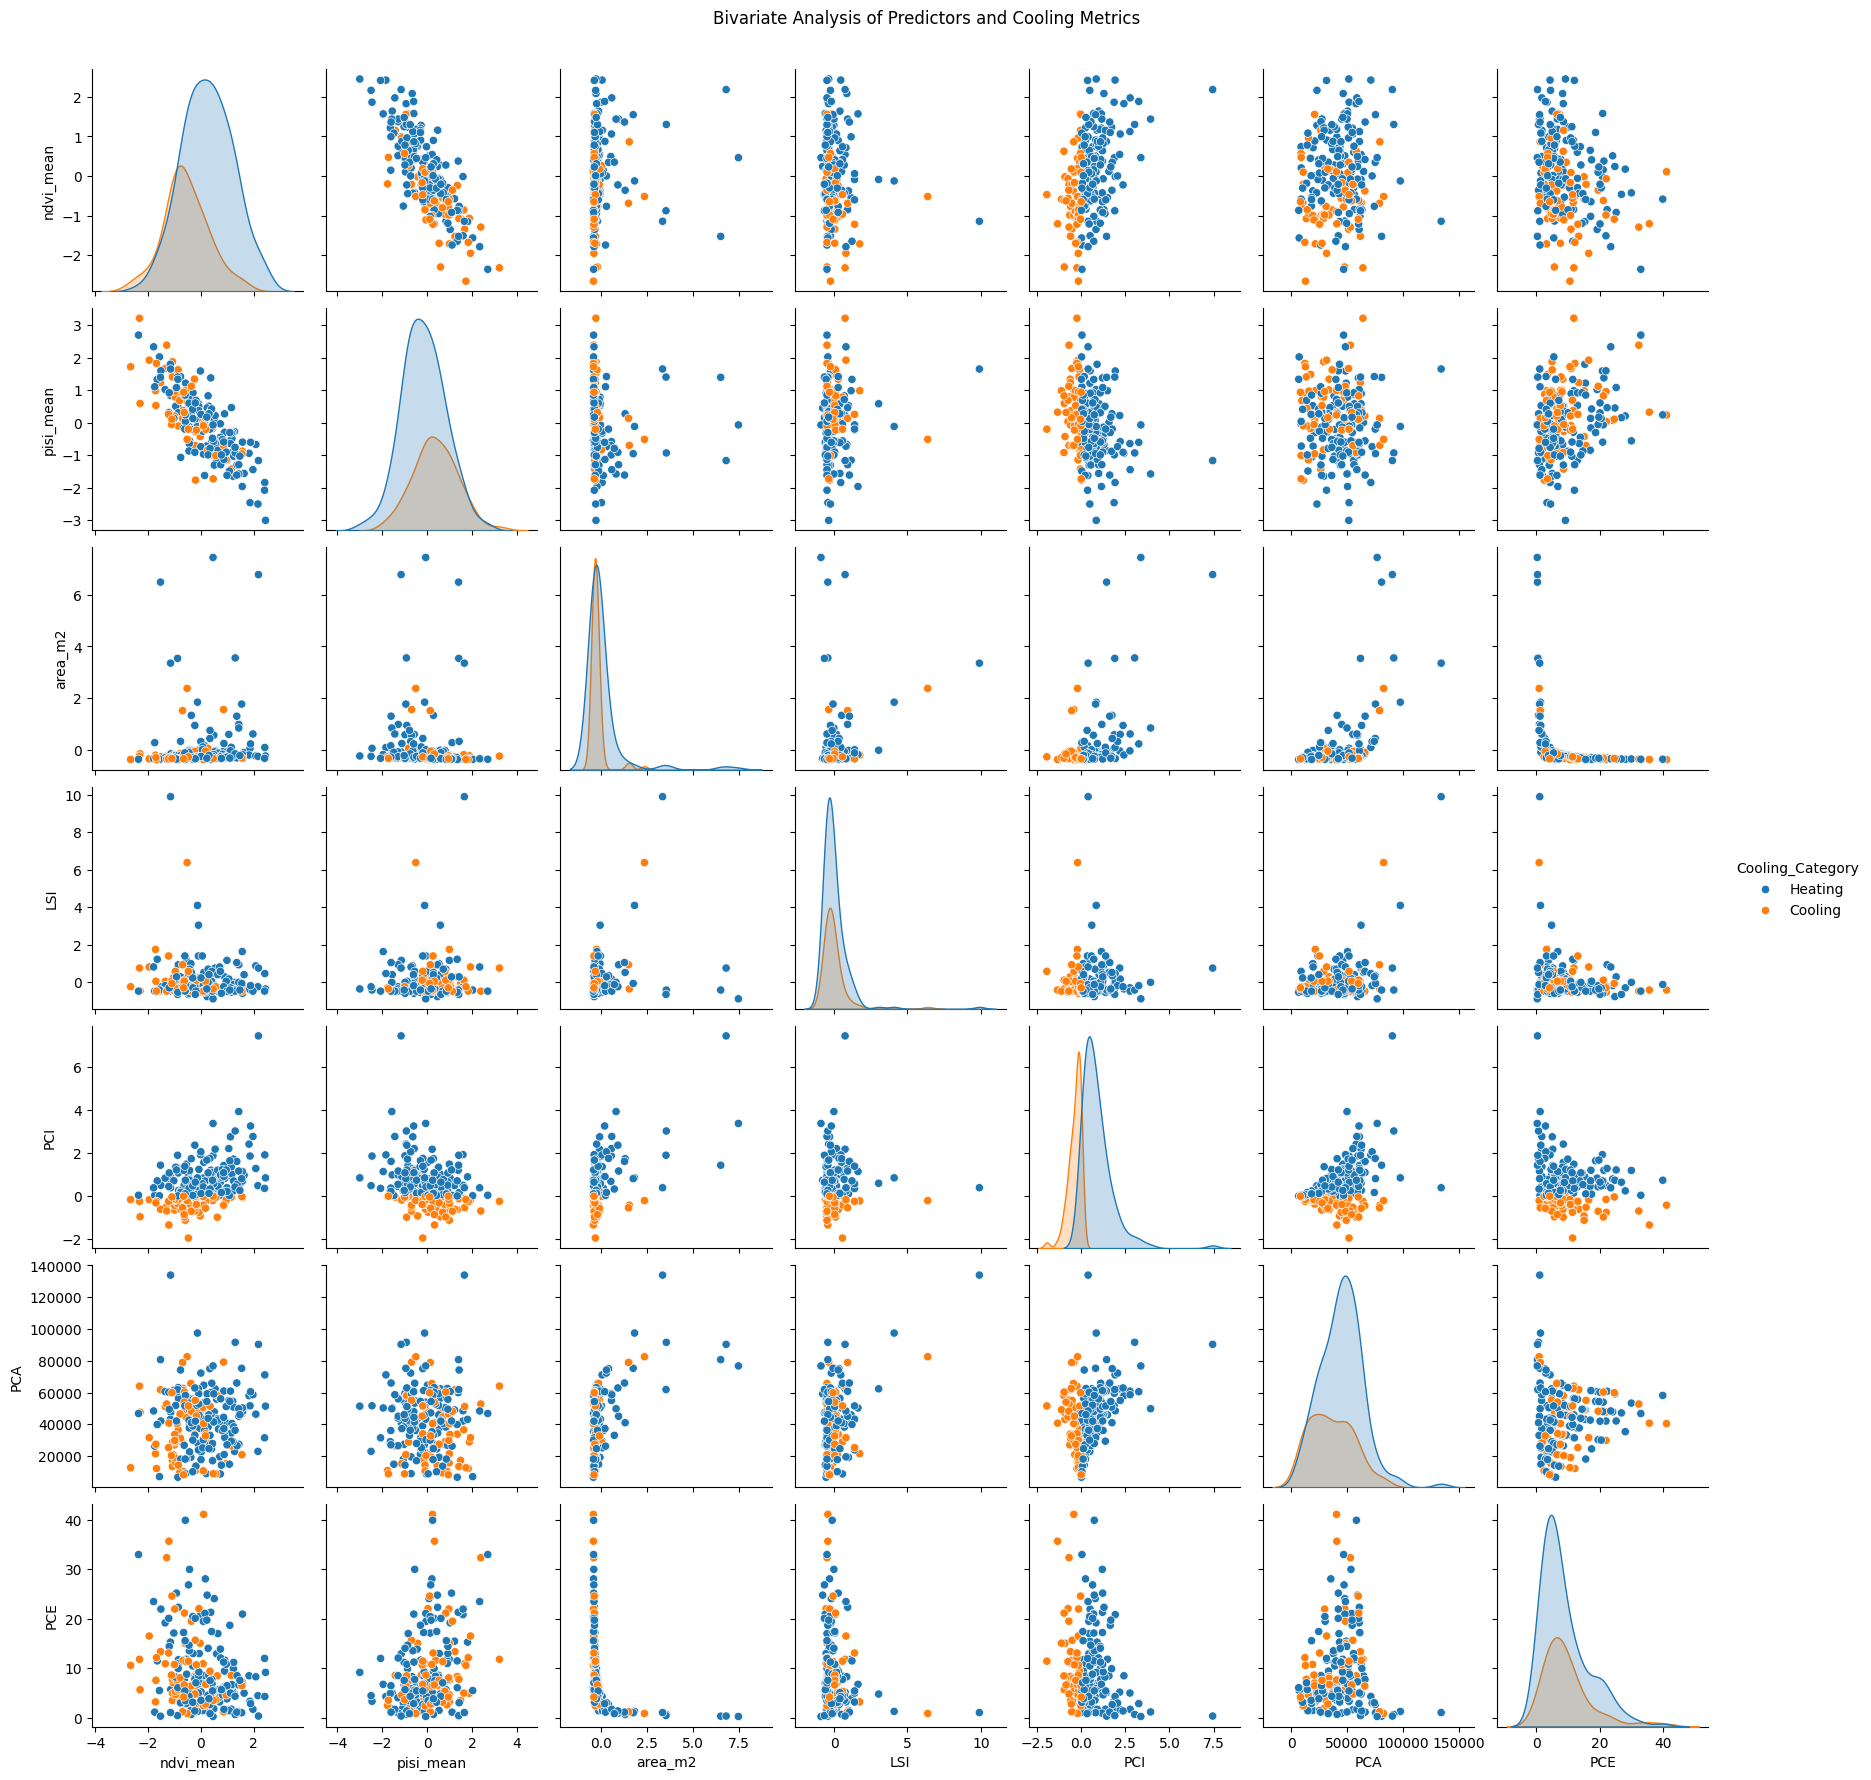

In [7]:
data_df['PCI'] = pd.to_numeric(data_df['PCI'], errors='coerce')  # Convert to numeric

# Add hue column for cooling/heating categorization
data_df['Cooling_Category'] = data_df['PCI'].apply(lambda x: 'Cooling' if x < 0 else 'Heating')

# Bivariate analysis with corrected hue
sns.pairplot(data_df, hue='Cooling_Category', vars=['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI', 'PCI', 'PCA', 'PCE'], diag_kind='kde')
plt.suptitle('Bivariate Analysis of Predictors and Cooling Metrics', y=1.02)
plt.show()

# 3. Regression Analysis

## 3.1. Model 1

From the correlation matrix, ndvi_mean and pisi_mean show strong negative correlation (r = -0.802), including both in the same model will cause multicollinearity problems (unstable coefficients, inflated standard errors)

In [13]:
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [14]:
# Create copies of the original DataFrame for different scenarios
df_pci = data_df.copy()  # For PCI models
df_pca = data_df.copy()  # For PCA models
df_pce = data_df.copy()  # For PCE models

# Initialize results storage
results = []

In [15]:
# Initialize results storage
results = []

In [16]:
# ========================================================
# 1. Park Cooling Intensity (PCI) Models
# ========================================================
X1_selected = df_pci[['ndvi_mean', 'area_m2']]
X1_all = df_pci[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']]
y1 = df_pci['PCI']

# OLS with selected features
X = sm.add_constant(X1_selected)
ols1_sel = sm.OLS(y1, X).fit()
y_pred = ols1_sel.predict(X)
results.append({
    'Dependent': 'PCI',
    'Model': 'OLS',
    'Features': 'Selected',
    'R2_adj': ols1_sel.rsquared_adj,
    'AIC': ols1_sel.aic,
    'BIC': ols1_sel.bic,
    'RMSE': np.sqrt(mean_squared_error(y1, y_pred)),
    'Features_used': list(X1_selected.columns)
})

# OLS with all features
X = sm.add_constant(X1_all)
ols1_all = sm.OLS(y1, X).fit()
y_pred = ols1_all.predict(X)
results.append({
    'Dependent': 'PCI',
    'Model': 'OLS',
    'Features': 'All',
    'R2_adj': ols1_all.rsquared_adj,
    'AIC': ols1_all.aic,
    'BIC': ols1_all.bic,
    'RMSE': np.sqrt(mean_squared_error(y1, y_pred)),
    'Features_used': list(X1_all.columns)
})

# Ridge regression with all features
X_train, X_test, y_train, y_test = train_test_split(
    X1_all, y1, test_size=0.2, random_state=42
)
ridge1 = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100]).fit(X_train, y_train)
y_pred = ridge1.predict(X_test)
results.append({
    'Dependent': 'PCI',
    'Model': 'Ridge',
    'Features': 'All',
    'R2_adj': r2_score(y_test, y_pred),
    'AIC': None,
    'BIC': None,
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Features_used': list(X1_all.columns),
    'Best_alpha': ridge1.alpha_
})


In [17]:
# ========================================================
# 2. Park Cooling Area (PCA) Models
# ========================================================
X2_selected = df_pca[['area_m2', 'LSI']]
X2_all = df_pca[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']]
y2 = df_pca['PCA']

# OLS with selected features
X = sm.add_constant(X2_selected)
ols2_sel = sm.OLS(y2, X).fit()
y_pred = ols2_sel.predict(X)
results.append({
    'Dependent': 'PCA',
    'Model': 'OLS',
    'Features': 'Selected',
    'R2_adj': ols2_sel.rsquared_adj,
    'AIC': ols2_sel.aic,
    'BIC': ols2_sel.bic,
    'RMSE': np.sqrt(mean_squared_error(y2, y_pred)),
    'Features_used': list(X2_selected.columns)
})

# Ridge regression with all features
X_train, X_test, y_train, y_test = train_test_split(
    X2_all, y2, test_size=0.2, random_state=42
)
ridge2 = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100]).fit(X_train, y_train)
y_pred = ridge2.predict(X_test)
results.append({
    'Dependent': 'PCA',
    'Model': 'Ridge',
    'Features': 'All',
    'R2_adj': r2_score(y_test, y_pred),
    'AIC': None,
    'BIC': None,
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Features_used': list(X2_all.columns),
    'Best_alpha': ridge2.alpha_
})

In [18]:
# ========================================================
# 3. Park Cooling Efficiency (PCE) Models
# ========================================================
# Use only pisi_mean (drop ndvi_mean to avoid multicollinearity)
X3_selected = df_pce[['pisi_mean', 'area_m2', 'LSI']]
X3_all = df_pce[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']]
y3 = df_pce['PCE']

# OLS with selected features
X = sm.add_constant(X3_selected)
ols3_sel = sm.OLS(y3, X).fit()
y_pred = ols3_sel.predict(X)
results.append({
    'Dependent': 'PCE',
    'Model': 'OLS',
    'Features': 'Selected',
    'R2_adj': ols3_sel.rsquared_adj,
    'AIC': ols3_sel.aic,
    'BIC': ols3_sel.bic,
    'RMSE': np.sqrt(mean_squared_error(y3, y_pred)),
    'Features_used': list(X3_selected.columns)
})

In [19]:
# Ridge regression with all features
X_train, X_test, y_train, y_test = train_test_split(
    X3_all, y3, test_size=0.2, random_state=42
)
ridge3 = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100]).fit(X_train, y_train)
y_pred = ridge3.predict(X_test)
results.append({
    'Dependent': 'PCE',
    'Model': 'Ridge',
    'Features': 'All',
    'R2_adj': r2_score(y_test, y_pred),
    'AIC': None,
    'BIC': None,
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'Features_used': list(X3_all.columns),
    'Best_alpha': ridge3.alpha_
})

In [20]:
# ========================================================
# Results Compilation
# ========================================================
results_df = pd.DataFrame(results)
print("Performance Comparison:")
print(results_df[['Dependent', 'Model', 'Features', 'R2_adj', 'AIC', 'BIC', 'RMSE']])

# Generate OLS summaries
print("\n===== PCI Model Summary (Selected Features) =====")
print(ols1_sel.summary())

print("\n===== PCA Model Summary (Selected Features) =====")
print(ols2_sel.summary())

print("\n===== PCE Model Summary (Selected Features) =====")
print(ols3_sel.summary())

Performance Comparison:
  Dependent  Model  Features    R2_adj          AIC          BIC          RMSE
0       PCI    OLS  Selected  0.404890   506.989379   517.183867      0.751655
1       PCI    OLS       All  0.408747   507.515514   524.506327      0.745770
2       PCI  Ridge       All  0.483053          NaN          NaN      0.885814
3       PCA    OLS  Selected  0.310963  4913.906811  4924.101299  16073.432442
4       PCA  Ridge       All  0.129270          NaN          NaN  16231.944321
5       PCE    OLS  Selected  0.200853  1480.505881  1494.098532      6.770147
6       PCE  Ridge       All  0.071521          NaN          NaN      7.923741

===== PCI Model Summary (Selected Features) =====
                            OLS Regression Results                            
Dep. Variable:                    PCI   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:    

Compare OLS Models:

In [21]:
# Top models for each cooling metric
top_models = results_df.sort_values(
    by=['Dependent', 'R2_adj'], 
    ascending=[True, False]
).groupby('Dependent').first()

In [22]:
top_models

,Model,Features,R2_adj,AIC,BIC,RMSE,Features_used,Best_alpha
Dependent,,,,,,,,
PCA,OLS,Selected,0.310963,4913.906811,4924.101299,16073.432442,"[area_m2, LSI]",10.0
PCE,OLS,Selected,0.200853,1480.505881,1494.098532,6.770147,"[pisi_mean, area_m2, LSI]",10.0
PCI,Ridge,All,0.483053,507.515514,524.506327,0.885814,"[ndvi_mean, pisi_mean, area_m2, LSI]",10.0
